In [11]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ToPILImage
import numpy as np
import skimage
import matplotlib.pyplot as plt

import scipy

import time
import gc

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

!pip install gemmi
import gemmi

In [12]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

# Analyzing number of parameters

In [13]:
def count_model_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
'''
trpv1_base_model = torch.load("trpv1_siren_model.pt")
trpv1_base_model.eval()
trpv1_model_num_parameters = count_model_parameters(trpv1_base_model)
trpv1_base_reconstruction = np.load("trpv1_siren_reconstruction.npy")
trpv1_voxel_num_parameters = trpv1_base_reconstruction.size
'''

'\ntrpv1_base_model = torch.load("trpv1_siren_model.pt")\ntrpv1_base_model.eval()\ntrpv1_model_num_parameters = count_model_parameters(trpv1_base_model)\ntrpv1_base_reconstruction = np.load("trpv1_siren_reconstruction.npy")\ntrpv1_voxel_num_parameters = trpv1_base_reconstruction.size\n'

In [15]:
# print(trpv1_model_num_parameters)
# print(trpv1_voxel_num_parameters)

# Analyzing Resolution Based on Omega

In [16]:
from IPython.display import clear_output

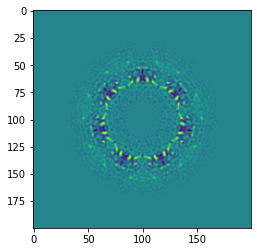

In [17]:
create_structure_from_scratch = True

if create_structure_from_scratch: 
    # Getting test T20S map
    if not os.path.exists('emd_6287.map.gz'):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-6287/map/emd_6287.map.gz
    if not os.path.exists('emd_6287.map'):
        !gunzip 'emd_6287.map.gz'
    map_path = 'emd_6287.map'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map(map_path)
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)
    
    structure = np.expand_dims(raw_structure, axis=-1)
    structure = structure[50:-50, 50:-50, 50:-50, :]
    plt.imshow(structure[:, :, structure.shape[0] // 2])
    plt.show()
    # structure = scipy.ndimage.zoom(structure, (0.5, 0.5, 0.5, 1))
    
    # with open('t20s_original_structure_reduced.npy', 'wb') as f:
    #     np.save(f, structure)
else:
    structure = np.load('t20s_original_structure_reduced.npy')
    
px_to_A = 0.98 # T20S dataset specific

In [18]:
t20s_results = np.empty((3, 3))
t20s_plots = {}

7812 / 7813


/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide


Resolution: 5.3741935483870975


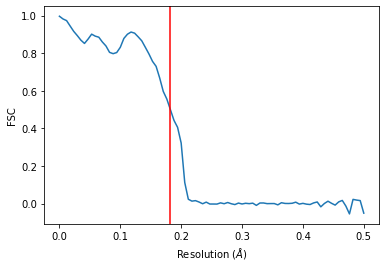

In [19]:
for hidden_idx, hidden_features in enumerate([256, 512, 768]):
    for omega_idx, omega in enumerate([30, 50, 70]):
        torch.cuda.empty_cache()
        gc.collect()
        
        siren_model = torch.load('t20s_siren_model_hidden' + str(hidden_features) +'_omega' + str(omega) + '.pt')
        siren_model.eval()
        
        desired_shape = structure.shape[0]

        input_coords = get_mgrid(desired_shape, 3)
        dataloader = DataLoader(input_coords, batch_size=1024, pin_memory=True, num_workers=0)

        all_coords = []
        all_densities = []

        num_processed = 0
        num_input = 0
        for batch, model_input in enumerate(dataloader):
            clear_output()
            print(batch, '/', len(dataloader))

            model_input = model_input.cuda()

            model_output, coords = siren_model(model_input)
            all_coords.append(coords.cpu().detach().numpy().squeeze())
            # all_coords.append(model_input.cpu().detach().numpy().squeeze())
            all_densities.append(model_output.cpu().detach().numpy().squeeze())
            num_processed += len(model_output.cpu().detach().numpy().squeeze())
            num_input += len(model_input)

        all_coords = np.concatenate(all_coords, axis=0)
        all_densities = np.concatenate(all_densities, axis=0)

        all_coords_transformed = np.stack(np.meshgrid(*(3 * [np.linspace(0, desired_shape - 1, desired_shape)])), axis=-1).reshape(-1, 3).astype(int)

        all_coords_z = all_coords_transformed[:, 0]
        all_coords_y = all_coords_transformed[:, 1]
        all_coords_x = all_coords_transformed[:, 2]

        final_siren_output = np.zeros((desired_shape, desired_shape, desired_shape))
        final_siren_output[all_coords_y, all_coords_z, all_coords_x] = all_densities
        
        # Based on https://tttrlib.readthedocs.io/en/latest/auto_examples/imaging/plot_imaging_frc.html

        # Arguments
        shell_size = 2
        epsilon = 1e-7

        original_image = structure
        pred_image = final_siren_output

        # Calculations
        F1 = np.fft.fftn(original_image.squeeze() / np.sum(original_image), axes=(0,1,2))
        F2 = np.fft.fftn(pred_image.squeeze() / np.sum(pred_image), axes=(0,1,2))

        F1F2 = np.real(F1 * np.conj(F2))
        F1_abs_squared = np.abs(F1)**2
        F2_abs_squared = np.abs(F2)**2

        nx, ny, nz = F1F2.shape
        x = np.arange(-np.floor(nx / 2.0), np.ceil(nx / 2.0))
        y = np.arange(-np.floor(ny / 2.0), np.ceil(ny / 2.0))
        z = np.arange(-np.floor(nz / 2.0), np.ceil(nz / 2.0))

        distances = []
        numerators = []
        F1_norms = []
        F2_norms = []

        for xi, yi, zi in np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3):
            distances.append(np.sqrt((xi ** 2) + (yi ** 2) + (zi ** 2)))
            xi = int(xi)
            yi = int(yi)
            zi = int(zi)

            numerators.append(F1F2[xi, yi, zi])
            F1_norms.append(F1_abs_squared[xi, yi, zi])
            F2_norms.append(F2_abs_squared[xi, yi, zi])

        bins = np.arange(0, np.sqrt(((nx // 2) ** 2) + ((ny // 2) ** 2) + ((nz // 2) ** 2)), shell_size)
        F1F2_histogram, bin_edges = np.histogram(
            distances,
            bins=bins,
            weights=numerators
        )
        F1_norm_histogram, bin_edges = np.histogram(
            distances,
            bins=bins,
            weights=F1_norms
        )
        F2_norm_histogram, bin_edges = np.histogram(
            distances,
            bins=bins,
            weights=F2_norms
        )

        FSC_vals = F1F2_histogram / np.sqrt(F1_norm_histogram * F2_norm_histogram)

        def convert_freq_to_resolution(frequencies, px_to_A):
            resolutions = 1 / frequencies
            resolutions[resolutions == np.inf] = 0
            resolutions *= px_to_A

            return resolutions

        # Setting up x-axis
        frequencies = np.linspace(0, 0.5, num=len(FSC_vals))
        resolutions = convert_freq_to_resolution(frequencies, px_to_A)

        # FSC_vals *= -1 # Remove later

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(frequencies, FSC_vals)
        # ax.set_xticklabels(np.around(convert_freq_to_resolution(ax.get_xticks(), px_to_A), 2))
        negligible_threshold_check = np.where((FSC_vals < 0.5) == True)[0]
        if len(negligible_threshold_check) > 0:
            resolution = resolutions[negligible_threshold_check[0]]
            ax.axvline(x=frequencies[negligible_threshold_check[0]], color='red')
            print("Resolution:", resolution)
        # ax.set_xlabel('Frequency (1/px)')
        ax.set_xlabel('Resolution (' + r'$\AA$' + ')')
        ax.set_ylabel('FSC')
        plt.show()
        
        t20s_results[hidden_idx, omega_idx] = resolution
        t20s_plots[(hidden_idx, omega_idx)] = fig

In [20]:
print(t20s_results)

[[5.37419355 5.20625    5.55333333]
 [0.         4.9        5.04848485]
 [5.04848485 5.20625    5.37419355]]


|                 |  |         |         |        |
|-----------------|-------|------------|------------|------------|
| **Hidden Features** |  **Omega**     |    **30**        |  **50**          |   **70**         |
| **256**             |       | 5.37419355 | 5.20625      | 5.55333333      |
| **512**             |       | 0.      | 4.9 | 5.04848485 |
| **768**             |       | 5.04848485 | 5.20625 | 5.37419355 |

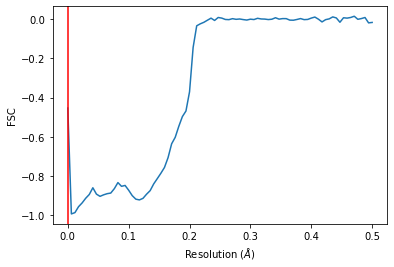

In [22]:
t20s_plots[(1, 0)]

In [23]:
t20s_base_model = torch.load("t20s_siren_model.pt")
t20s_base_model.eval()
structure = np.load('t20s_original_structure_reduced.npy')

976 / 977


/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator


Resolution: 2.2866666666666666


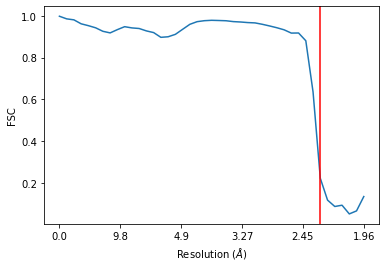

In [24]:
desired_shape = structure.shape[0]

input_coords = get_mgrid(desired_shape, 3)
dataloader = DataLoader(input_coords, batch_size=1024, pin_memory=True, num_workers=0)

all_coords = []
all_densities = []

num_processed = 0
num_input = 0
for batch, model_input in enumerate(dataloader):
    clear_output()
    print(batch, '/', len(dataloader))

    model_input = model_input.cuda()

    model_output, coords = siren_model(model_input)
    all_coords.append(coords.cpu().detach().numpy().squeeze())
    # all_coords.append(model_input.cpu().detach().numpy().squeeze())
    all_densities.append(model_output.cpu().detach().numpy().squeeze())
    num_processed += len(model_output.cpu().detach().numpy().squeeze())
    num_input += len(model_input)

all_coords = np.concatenate(all_coords, axis=0)
all_densities = np.concatenate(all_densities, axis=0)

all_coords_transformed = np.stack(np.meshgrid(*(3 * [np.linspace(0, desired_shape - 1, desired_shape)])), axis=-1).reshape(-1, 3).astype(int)

all_coords_z = all_coords_transformed[:, 0]
all_coords_y = all_coords_transformed[:, 1]
all_coords_x = all_coords_transformed[:, 2]

final_siren_output = np.zeros((desired_shape, desired_shape, desired_shape))
final_siren_output[all_coords_y, all_coords_z, all_coords_x] = all_densities

# Based on https://tttrlib.readthedocs.io/en/latest/auto_examples/imaging/plot_imaging_frc.html

# Arguments
shell_size = 2
epsilon = 1e-7

original_image = structure
pred_image = final_siren_output

# Calculations
F1 = np.fft.fftn(original_image.squeeze() / np.sum(original_image), axes=(0,1,2))
F2 = np.fft.fftn(pred_image.squeeze() / np.sum(pred_image), axes=(0,1,2))

F1F2 = np.real(F1 * np.conj(F2))
F1_abs_squared = np.abs(F1)**2
F2_abs_squared = np.abs(F2)**2

nx, ny, nz = F1F2.shape
x = np.arange(-np.floor(nx / 2.0), np.ceil(nx / 2.0))
y = np.arange(-np.floor(ny / 2.0), np.ceil(ny / 2.0))
z = np.arange(-np.floor(nz / 2.0), np.ceil(nz / 2.0))

distances = []
numerators = []
F1_norms = []
F2_norms = []

for xi, yi, zi in np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3):
    distances.append(np.sqrt((xi ** 2) + (yi ** 2) + (zi ** 2)))
    xi = int(xi)
    yi = int(yi)
    zi = int(zi)

    numerators.append(F1F2[xi, yi, zi])
    F1_norms.append(F1_abs_squared[xi, yi, zi])
    F2_norms.append(F2_abs_squared[xi, yi, zi])

bins = np.arange(0, np.sqrt(((nx // 2) ** 2) + ((ny // 2) ** 2) + ((nz // 2) ** 2)), shell_size)
F1F2_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=numerators
)
F1_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F1_norms
)
F2_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F2_norms
)

FSC_vals = F1F2_histogram / np.sqrt(F1_norm_histogram * F2_norm_histogram)

def convert_freq_to_resolution(frequencies, px_to_A):
    resolutions = 1 / frequencies
    resolutions[resolutions == np.inf] = 0
    resolutions *= px_to_A
    
    return resolutions

# Setting up x-axis
frequencies = np.linspace(0, 0.5, num=len(FSC_vals))
px_to_A = 0.98 # T20S dataset specific
resolutions = convert_freq_to_resolution(frequencies, px_to_A)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(frequencies, FSC_vals)
ax.set_xticklabels(np.around(convert_freq_to_resolution(ax.get_xticks(), px_to_A), 2))
negligible_threshold_check = np.where((FSC_vals < 0.5) == True)[0]
if len(negligible_threshold_check) > 0:
    resolution = resolutions[negligible_threshold_check[0]]
    ax.axvline(x=frequencies[negligible_threshold_check[0]], color='red')
    print("Resolution:", resolution)
# ax.set_xlabel('Frequency (1/px)')
ax.set_xlabel('Resolution (' + r'$\AA$' + ')')
ax.set_ylabel('FSC')
plt.show()

In [31]:
t20s_base_reconstruction = np.load('t20s_original_structure_reduced.npy')

In [32]:
import scipy.ndimage

In [33]:
final_siren_output = scipy.ndimage.zoom(t20s_base_reconstruction.squeeze(), (2, 2, 2))

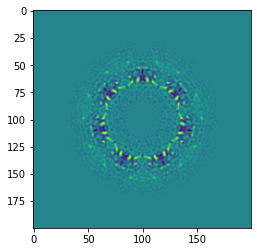

In [34]:
create_structure_from_scratch = True

if create_structure_from_scratch: 
    # Getting test T20S map
    if not os.path.exists('emd_6287.map.gz'):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-6287/map/emd_6287.map.gz
    if not os.path.exists('emd_6287.map'):
        !gunzip 'emd_6287.map.gz'
    map_path = 'emd_6287.map'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map(map_path)
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)
    
    structure = np.expand_dims(raw_structure, axis=-1)
    structure = structure[50:-50, 50:-50, 50:-50, :]
    plt.imshow(structure[:, :, structure.shape[0] // 2])
    plt.show()
    # structure = scipy.ndimage.zoom(structure, (0.5, 0.5, 0.5, 1))
    
    # with open('t20s_original_structure_reduced.npy', 'wb') as f:
    #     np.save(f, structure)
else:
    structure = np.load('t20s_original_structure_reduced.npy')
    
px_to_A = 0.98 # T20S dataset specific

/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Resolution: 4.9


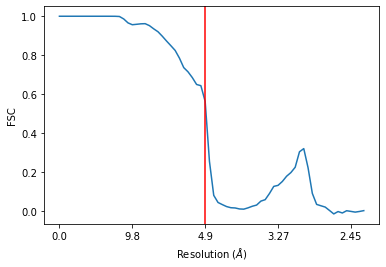

In [35]:
# Based on https://tttrlib.readthedocs.io/en/latest/auto_examples/imaging/plot_imaging_frc.html

# Arguments
shell_size = 2
epsilon = 1e-7

original_image = structure
pred_image = final_siren_output

# Calculations
F1 = np.fft.fftn(original_image.squeeze() / np.sum(original_image), axes=(0,1,2))
F2 = np.fft.fftn(pred_image.squeeze() / np.sum(pred_image), axes=(0,1,2))

F1F2 = np.real(F1 * np.conj(F2))
F1_abs_squared = np.abs(F1)**2
F2_abs_squared = np.abs(F2)**2

nx, ny, nz = F1F2.shape
x = np.arange(-np.floor(nx / 2.0), np.ceil(nx / 2.0))
y = np.arange(-np.floor(ny / 2.0), np.ceil(ny / 2.0))
z = np.arange(-np.floor(nz / 2.0), np.ceil(nz / 2.0))

distances = []
numerators = []
F1_norms = []
F2_norms = []

for xi, yi, zi in np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3):
    distances.append(np.sqrt((xi ** 2) + (yi ** 2) + (zi ** 2)))
    xi = int(xi)
    yi = int(yi)
    zi = int(zi)
    
    numerators.append(F1F2[xi, yi, zi])
    F1_norms.append(F1_abs_squared[xi, yi, zi])
    F2_norms.append(F2_abs_squared[xi, yi, zi])
    
bins = np.arange(0, np.sqrt(((nx // 2) ** 2) + ((ny // 2) ** 2) + ((nz // 2) ** 2)), shell_size)
F1F2_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=numerators
)
F1_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F1_norms
)
F2_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F2_norms
)

FSC_vals = F1F2_histogram / np.sqrt(F1_norm_histogram * F2_norm_histogram)

def convert_freq_to_resolution(frequencies, px_to_A):
    resolutions = 1 / frequencies
    resolutions[resolutions == np.inf] = 0
    resolutions *= px_to_A
    
    return resolutions


# Setting up x-axis
frequencies = np.linspace(0, 0.5, num=len(FSC_vals))
px_to_A = 0.98 # t20s dataset specific
resolutions = convert_freq_to_resolution(frequencies, px_to_A)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(frequencies, FSC_vals)
ax.set_xticklabels(np.around(convert_freq_to_resolution(ax.get_xticks(), px_to_A), 2))
negligible_threshold_check = np.where((FSC_vals < 0.5) == True)[0]
if len(negligible_threshold_check) > 0:
    resolution = resolutions[negligible_threshold_check[0] - 1]
    ax.axvline(x=frequencies[negligible_threshold_check[0] - 1], color='red')
    print("Resolution:", resolution)
# ax.set_xlabel('Frequency (1/px)')
ax.set_xlabel('Resolution (' + r'$\AA$' + ')')
ax.set_ylabel('FSC')
plt.show()

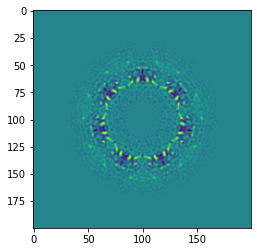

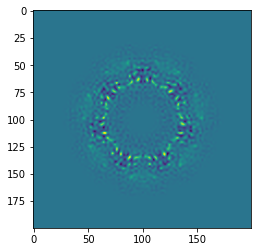

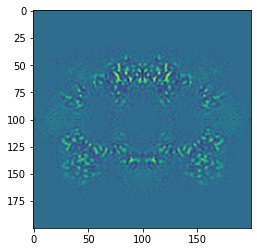

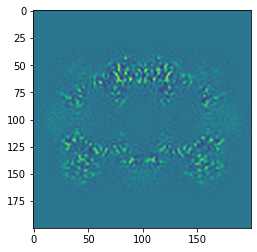

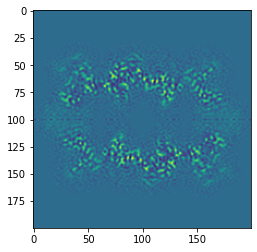

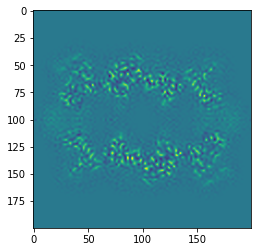

In [36]:
plt.imshow(structure[:, :, structure.shape[2] // 2])
plt.show()
plt.imshow(final_siren_output[:, :, final_siren_output.shape[2] // 2])
plt.show()
plt.imshow(structure[:, structure.shape[1] // 2, :])
plt.show()
plt.imshow(final_siren_output[:, final_siren_output.shape[1] // 2, :])
plt.show()
plt.imshow(structure[structure.shape[0] // 2, :, :])
plt.show()
plt.imshow(final_siren_output[final_siren_output.shape[0] // 2, :, :])
plt.show()